In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from copy import deepcopy
from matplotlib import pyplot
from scipy import stats
import logging
import matplotlib
import matplotlib.gridspec as gridspec
import os
import pandas
import string, math, numpy
import sys, os, glob, csv, re
import subprocess

In [4]:
#pyplot.style.use('dark_background')
logging.basicConfig(level=logging.INFO)

In [5]:
try:
    from ltrack import config
    import ltrack.lineage.inference_params as inference_params
    import ltrack.lineage.file_parser as file_parser
    from ltrack.lineage.fitness_estimator import *
except ImportError:
    print("Please install the LineageTracking package by running the command line 'pip install .' in the lineage_tracking repository's root directory.")
    raise
except: raise

In [6]:
project_name = os.path.basename(os.getcwd())

In [7]:
population = project_name

In [8]:
barcode_lists = {}

In [9]:
#read data
timepoints, data, counts = file_parser.get_data(population, config.barcode_data_root_directory)
max_barcode = config.max_barcode[population]

INFO:root:Processing population LT_5epochs.
INFO:root:Reading files.
INFO:root:Reading files complete.


In [10]:
#read kappas
kappas = file_parser.read_kappas_from_file(config.error_model_directory+population+'-kappas.tsv')

In [11]:
#loop through the different environments
environment = 'evolution'

In [12]:
#read empirical null distribution and q-values
empirical_null, t_statistic_95_percent_cutoff = file_parser.read_empirical_null_from_file(
                                                                        config.error_model_directory
                                                                        +population
                                                                        +'-empirical_null_%s.tsv'%environment)

In [13]:
qvals = file_parser.read_q_values_from_file(config.error_model_directory+population+'-q_values_%s.tsv'%environment)

In [14]:
#initialize fitness estimator object
fitness_estimator = FitnessEstimator(counts, kappas, 
                                        qvals = qvals,
                                        t_statistic_95_percent_cutoff = t_statistic_95_percent_cutoff,
                                        empirical_null = empirical_null
                                    )

In [15]:
barcoding = False

In [16]:
#estimate relative fitnesses
#ensure all lineage fitnesses are zero to start with
for dataset in range(0,max_barcode):
    for parent_id in data[dataset].keys():
        for bcd, lineage in data[dataset][parent_id].items():
            lineage.relative_fitness = np.zeros(len(lineage.freqs)//INTERVALS_PER_EPOCH)
            lineage.relative_fitness_CI = [(0,0) for i in range(0,len(lineage.relative_fitness))]

In [17]:
fitness_estimator.population_fitness = numpy.zeros(len(fitness_estimator.population_fitness))

In [18]:
for target_epoch in range(0,max_barcode-barcoding):
    logging.info("Target epoch is %d.", target_epoch)

    converged = False
    it = 0

    while not converged and it < 40:

        if it > 0:
            logging.info("re-estimating... (it = %d)", it + 1)
        it +=1

        converged = True

        for using_barcode in range(0,target_epoch+1):

            begin, end = fitness_estimator.get_interval_endpoints(target_epoch, barcoding = barcoding)
            max_mean_fitness =deepcopy(fitness_estimator.population_fitness[begin:end])

            for parent_id in data[using_barcode].keys():
                for bcd, lineage in data[using_barcode][parent_id].items():
                    fitness_estimator.update_lineage_fitness(lineage, target_epoch, barcoding = barcoding)

            fitness_estimator.update_mean_fitness(data[using_barcode], target_epoch, barcoding = barcoding)

            if fitness_estimator.population_fitness[end-1] > max_mean_fitness[-1] + 10**-6:
                converged = False
            else:
                fitness_estimator.population_fitness[begin:end] = max_mean_fitness

INFO:root:Target epoch is 0.
/home/grotec/Repositories/lineage-tracking/ltrack/lineage/fitness_estimator.py:60: RuntimeWarning: divide by zero encountered in log
  (np.sqrt(expectations) - np.sqrt(observed[1:]))**2/self.k[begin:end-1]  + 0.75* np.log(observed[1:]) - 0.25* np.log(expectations)
/home/grotec/Repositories/lineage-tracking/ltrack/lineage/fitness_estimator.py:138: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = 2*(neutral_llh - min_llh)
INFO:root:Target epoch is 1.
INFO:root:re-estimating... (it = 2)
INFO:root:Target epoch is 2.
INFO:root:re-estimating... (it = 2)
INFO:root:Target epoch is 3.
INFO:root:re-estimating... (it = 2)
INFO:root:Target epoch is 4.
INFO:root:re-estimating... (it = 2)


In [19]:
def get_fitnesses_for_barcode(using_barcode):

    logging.info("Writing data for epoch {}".format(using_barcode))
    with open(config.lineage_fitness_estimate_directory+'%s-BC%d_%s_fitnesses.csv' %  (population,using_barcode,environment), 'w') as csvfile: out_writer = csv.writer(csvfile, delimiter='\t')
        
    header_row = []
    for iepoch in  range(using_barcode, max_barcode+1):
        header_row += ["Epoch{0:d}".format(iepoch), "Epoch{0:d}-CI".format(iepoch), "Epoch{0:d}+CI".format(iepoch)]

    rows = []
    barcodes = []
    for parent_id in data[using_barcode - 1].keys():
        for bcd, lineage in data[using_barcode - 1][parent_id].items():
            if all(lineage.relative_fitness<=0):
                logging.debug("All fitnesses zero or less in lineage %s", lineage.ID)
                continue
            fitnesses = numpy.zeros(3*len(lineage.relative_fitness))
            barcodes.append(lineage.ID)

            fitnesses[::3] = lineage.relative_fitness
            fitnesses[1::3] = [lower[0] for lower in lineage.relative_fitness_CI]
            fitnesses[2::3] = [upper[1] for upper in lineage.relative_fitness_CI]

            rows.append(fitnesses)
    return rows, barcodes, header_row
           

In [20]:
using_barcode = 1

In [21]:
fitness_data, barcodes, headers = get_fitnesses_for_barcode(using_barcode)

INFO:root:Writing data for epoch 1


In [22]:
assert all([len(row) == 15 for row in fitness_data])

In [23]:
barcodes_index = pandas.Index(data=barcodes, name="BC")

In [24]:
 
fitnesses_df = pandas.DataFrame(index=barcodes_index,
                                columns=headers,
                                data=fitness_data,
                               )

fitnesses_df.to_csv(config.lineage_fitness_estimate_directory+'%s-BC%d_%s_fitnesses.csv' %  
                    (population,using_barcode,"evolution"),
                    sep='\t',
                    index=True)

In [25]:
fitnesses_df.shape

(34, 15)

In [26]:
idx = pandas.IndexSlice
using_barcode=1
iterables = [["Epoch {0:d}".format(epoch) for epoch in range(using_barcode,max_barcode+1)],
             ["fitness_mean", "fitness_CI_min", "fitness_CI_max"]
            ]
columns = pandas.MultiIndex.from_product(iterables, names=['Epoch', 'fitness'])

logging.info("Reading fitness data from %s.", os.path.join(
        config.lineage_fitness_estimate_directory,'{}-BC{}_{}_fitnesses.csv'.format(
            population,
            using_barcode,
            'evolution'
        )
    )
            )
             

fitnesses = pandas.read_csv(
    os.path.join(
        config.lineage_fitness_estimate_directory,'{}-BC{}_{}_fitnesses.csv'.format(
            population,
            using_barcode,
            'evolution'
        )
    ),
    sep='\t',
    index_col=0
)

INFO:root:Reading fitness data from /home/grotec/Repositories/lineage-tracking/data/relative_fitnesses/LT_5epochs-BC1_evolution_fitnesses.csv.


In [27]:
fitnesses.dropna(inplace=True, axis='columns')
fitnesses = fitnesses.iloc[:, :3*(max_barcode+1-using_barcode)]
fitnesses.columns = columns

for epoch in set(columns.get_level_values(level="Epoch")):
    fitnesses[(epoch, 'fitness_CI')] = fitnesses[(epoch, "fitness_CI_max")] - fitnesses[(epoch, "fitness_CI_min")]

fitnesses.sort_index(level="Epoch", inplace=True, axis=1)

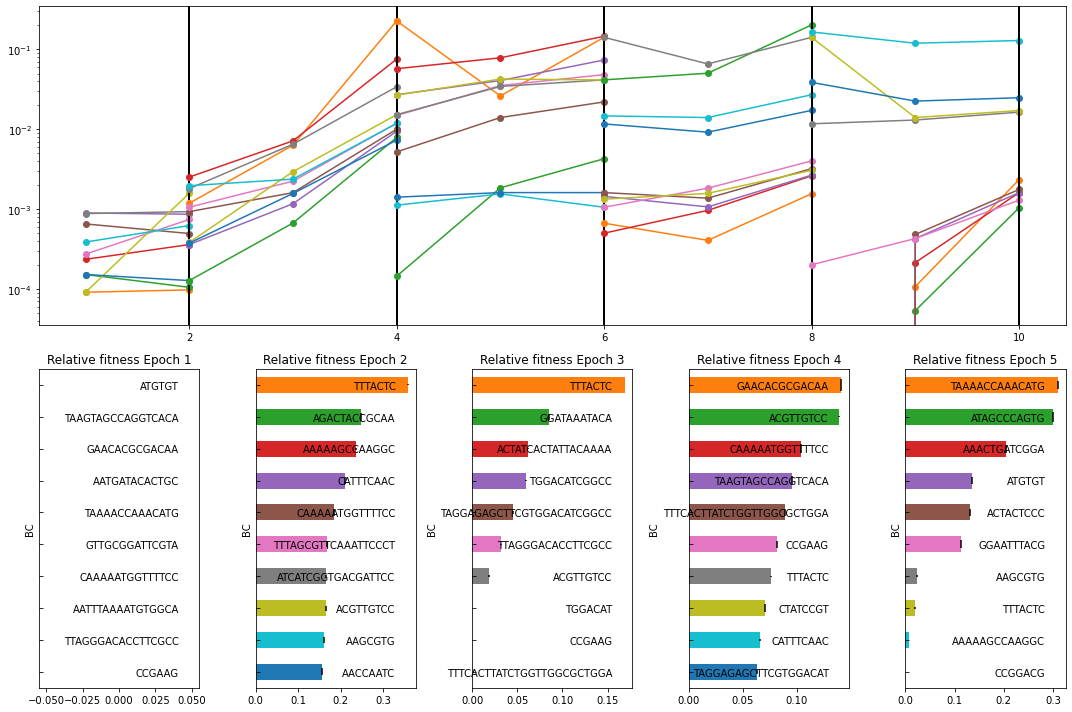

In [28]:
fig, axs = pyplot.subplots(2,len(set(fitnesses.columns.get_level_values(level="Epoch"))), figsize=(15,10))
gridspec = axs[0,0].get_gridspec()
for ax in axs[0,:]:
    ax.remove()
joined_ax = fig.add_subplot(gridspec[0,:])  
max_freq = 0.0
epochs = sorted(set(fitnesses.columns.get_level_values(level="Epoch")))
top = 10
colors=['C{0:d}'.format(n) for n in range(1,top+1)]

for iepoch,epoch in enumerate(epochs):
    # Get fitnesses for this epoch and sort in descending order by fitness mean.
    tmp = (fitnesses.loc[:,idx[epoch,["fitness_mean", "fitness_CI"]]])
    # We don't need the Epoch column level.
    tmp.columns = tmp.columns.droplevel(level="Epoch")
    tmp = tmp.sort_values(by="fitness_mean",axis='index', ascending=False).head(top)
    
    
    # Plot lineage frequencies for top lineages.
    top_freqs = [list(data[0].values())[0][bc] for bc in tmp.index]
    begin, end = interval_endpoints(iepoch) 
    begin = max(0, begin-1)
    
    # Go through all top lineages and their frequencies.
    for ilineage, lineage in enumerate(top_freqs):
        tmp_max = lineage.freqs.max()
        if tmp_max > max_freq:
            max_freq = tmp_max
        
        # Plot before focal epoch
#         joined_ax.semilogy(range(1,len(lineage.freqs)+1)[:begin],
#                            lineage.freqs[:begin],
#                            color=colors[ilineage % top],
#                            linestyle="--",
#                            marker='x', 
#                           ) 
        joined_ax.semilogy(range(1,len(lineage.freqs)+1)[begin:end],
                           lineage.freqs[begin:end],
                           label=lineage.ID,
                           color=colors[ilineage % top],
                           marker='o'
                          ) 
#         joined_ax.semilogy(range(1,len(lineage.freqs)+1)[end:],
#                            lineage.freqs[end:],
#                            color=colors[ilineage % top],
#                            linestyle="--",
#                            marker='x', 
#                           ) 
        joined_ax.axvline(x=end, ymin=0, ymax=1, color='k')
        
    tmp.plot.barh(
        ax=axs[1,iepoch],
        y="fitness_mean",
        yerr="fitness_CI",
        legend=False,
        title="Relative fitness {}".format(epoch),
        color=colors,
    )
    axs[1,iepoch].tick_params(axis="y",direction="in", pad=-140)
    axs[1, iepoch].invert_yaxis()

    
#     joined_ax.legend()
# Get top 10 lineages and plot them over time in epoch.
pyplot.tight_layout()
fig.savefig("/tmp/fitness.png")

* how is the average fitness defined?


## Find lineages that have positive fitness for more than 1 epoch. Flag these as A, all others as C or P

In [29]:
positive_fitnesses = fitnesses_df.iloc[:,0::3][fitnesses_df>0]

In [30]:
positive_fitnesses.dropna(axis=0, thresh=2)

,Epoch1,Epoch2,Epoch3,Epoch4,Epoch5
BC,,,,,
AAGCGTG,NaN,0.162046,NaN,NaN,0.022927
TTTACTC,NaN,0.358500,0.169000,0.076500,0.020435
TGGACAT,NaN,0.084442,NaN,0.033398,NaN
AACCAATC,NaN,0.156065,NaN,0.054988,NaN
CTATCCGT,NaN,0.127842,NaN,0.070217,NaN
CATTTCAAC,NaN,0.210724,NaN,0.066059,NaN
ACGTTGTCC,NaN,0.165404,0.019140,0.139500,NaN
TGGACATCGGCC,NaN,0.093412,0.059202,0.036255,NaN
AAAAAGCCAAGGC,NaN,0.235919,NaN,0.045000,0.008000


In [31]:
## Flagging
flags = pandas.Series(
    index=pandas.Index(positive_fitnesses.index, name="BC"),
    data=["A"]*len(positive_fitnesses),
    name="flags")

In [32]:
flags_path = os.path.abspath(os.path.join("../../data/flags/", "{}-BC{}_flags.tsv".format(project_name, using_barcode)))
logging.info("Writing flags to %s.", flags_path)

INFO:root:Writing flags to /home/grotec/Repositories/lineage-tracking/data/flags/LT_5epochs-BC1_flags.tsv.


In [33]:
flags.to_csv(flags_path, sep="\t", index=True)

In [34]:
## Accepted clone
accepted_clones = pandas.Series(
    index=pandas.Index(positive_fitnesses.index, name="BC"),
    data=pandas.Index(positive_fitnesses.index, name="BC"),
)

In [35]:
accepted_clones_path = os.path.abspath(os.path.join("../../data/accepted_clones/", "{}_clone_list.tsv".format(project_name, using_barcode)))
logging.info("Writing accepted_clones to %s.", accepted_clones_path)

INFO:root:Writing accepted_clones to /home/grotec/Repositories/lineage-tracking/data/accepted_clones/LT_5epochs_clone_list.tsv.


In [36]:
accepted_clones.to_csv(accepted_clones_path, sep="\t", index=False, header=None)